In [1]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器。"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        #Python中的super(Net, self).__init__()是指首先找到Net的父类（比如是类NNet），
        # 然后把类Net的对象self转换为类NNet的对象，然后“被转换”的类NNet对象调用自己的
        # init函数，其实简单理解就是子类把父类的__init__()放到自己的__init__()当中
        # ，这样子类就有了父类的__init__()的那些东西。
        self.embedding = nn.Embedding(vocab_size, embed_size)#（字典大小，词向量大小）只是一个矩阵，然后做个映射
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)#特征维度，隐藏层神经元个数，rnn层数
    

    def forward(self, X, *args):
        X = self.embedding(X)#（batchSize,rnnCell个数）
        X = X.permute(1, 0, 2)#切换维度
        output, state = self.rnn(X)#（rnnCell个数，batchSize,inputSize）->(rnnCell个数,batchSize,hiddenSize),(rnn层数,batchSize,hiddenSize)
        return output, state

In [4]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape,state.shape

(torch.Size([7, 4, 16]), torch.Size([2, 4, 16]))

In [5]:
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器。"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        X = self.embedding(X).permute(1, 0, 2)#(7,4,8) rnnCell个数，batch，
        context = state[-1].repeat(X.shape[0], 1, 1)#取rnn最后一层的输出，重复encoder的rnnCell个数次
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)#输入tensor(rnnCell个数，batchSize,输入层维度)，隐藏tensor（num_layers,batchSize,隐藏层维度)
        output = self.dense(output).permute(1, 0, 2)
        return output, state

In [6]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))#torch.Size([2, 4, 16]))
output, state = decoder(X, state)#x.shape = (4, 7)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

In [7]:
def sequence_mask(X, valid_len, value=0):#valid_len的长度要和X的第一个维度长度相同
    """在序列中屏蔽不相关的项。"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]#张量广播，广播时，从尾部维度开始，满足尺寸大小相等或其中一个为1或其中一个不存在。
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [8]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)
sequence_mask(torch.ones(3, 4, 10), torch.tensor([4, 2, 0]))

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [9]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""

    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'#不对损失求平均，默认求平均
        unweighted_loss = super().forward(pred.permute(0, 2, 1), label)#不做处理，即self.reduction = 'none'，则结果维度不变
                                                                        #pred.permute --> batchSize,样本数量，样本的各类别概率,
        weighted_loss = (unweighted_loss * weights).mean(dim=1)# “哈达玛积”
        return weighted_loss

In [10]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

In [19]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型。"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)#xaiver初始化解决了神经网络中权重矩阵W的初始化设置问题。
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)  #pytorch中的model.apply(fn)会递归地将函数fn应用到
                                    #父模块的每个子模块submodule，也包括model这个父模块自身。
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',#画图
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)
        for batch in data_iter:
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()#求出梯度
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()#更新参数
            with torch.no_grad():
                metric.add(l.sum(),num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} 'f'tokens/sec on {str(device)}')

loss 0.019, 8358.5 tokens/sec on cuda:0


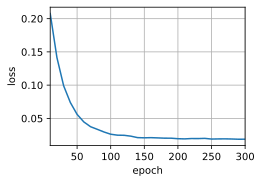

In [20]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)#num_steps：句子长度为10
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [54]:
torch.cuda.device_count()
d2l.load_data_nmt(batch_size, num_steps)

(<torch.utils.data.dataloader.DataLoader at 0x24c3dfdf2b0>,
 <d2l.torch.Vocab at 0x24c3dc9c2e0>)

In [14]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    dec_X = torch.unsqueeze(
        torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device),
        dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [ ]:
def bleu(pred_seq, label_seq, k):  
    """计算 BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i:i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i:i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i:i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')